In [371]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import autoreload  (for debugging external subroutines)
%load_ext autoreload
%autoreload 2

# subroutines needed, we also need kepcart.py
from orbsubs import *  
from outils import *
from scipy.signal import savgol_filter 
from scipy.ndimage import median_filter 

plt.rcParams.update({'font.size': 14})

# this file has current figures for a paper!


import pymesh
#https://pymesh.readthedocs.io/en/latest/basic.html
# https://github.com/PyMesh/PyMesh

import meshplot
# for display of meshes
#https://skoch9.github.io/meshplot/tutorial/

import random

# nicer plots
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


#https://quaternion.readthedocs.io/en/latest/
import quaternion

from byorp_subs import *
# my subroutines are moved here

# shape models available here:
#https://www.naic.edu/~smarshal/1999kw4.html
#Squannit is secondary of Moshup which was 1999KW4



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Binary simulation output plotting and doing BYORP with output of simulation 

In [399]:
# compute the BYORP torque B coeff, for a binary using simulation output
# arguments:
#   body: vertices, faces triangular surface mesh (in principal axis coordinate system)
#   tarr: time array
#   s_hat_arr: array of solar orientations
#   qarr: array of quaternions to rotate body
#   a_bin: array of binary directions
#   l_bin: orbit normal (not an array)
# returns:
#   torque dot l_bin so can compute binary orbit drift rate
def compute_BY_orbit(vertices,faces,tarr,s_hat_arr,qarr,abin_arr,l_bin):
    tau_l_arr = np.zeros(len(s_hat_arr))
    
    
    for i in range(len(tarr)):
        q = qarr[i]  # quaternion specifying body direction 
        a_x = abin_arr[i,0]  # binary direction
        a_y = abin_arr[i,1]
        a_z = abin_arr[i,2]
        s_hat = np.squeeze(s_hat_arr[i,:]) # solar direction vector
        # rotate the body!
        v = np.copy(vertices)
        tvertices =quaternion.rotate_vectors(q, v) 
        f_areas, f_normals = face_areas(tvertices,faces) # vector of facet areas and face normal vectors
        F_i_x,F_i_y,F_i_z = F_i(f_areas,f_normals,s_hat)   # forces on each facet 
        F_x = np.sum(F_i_x); F_y = np.sum(F_i_y); F_z = np.sum(F_i_z);  # sum forces 
        tau_x,tau_y,tau_z = cross_prod_xyz(a_x,a_y,a_z,F_x,F_y,F_z) # cross product
        #gives instantaneous BYORP torque
        tau_l = tau_x*l_bin[0] + tau_y*l_bin[1] + tau_z*l_bin[2]   # component along orbit normal
        #print(tau_l)
        tau_l_arr[i] = tau_l
        
    return tau_l_arr



# make array of solar directions 
#   tarr is time array
#   incl is solar orbit inclination , not used yet !!!!
#   omega_sun is how fast Sun advances on the sky angular rotation rate
def mk_s_hat(tarr,incl,omega_Sun):
    phi_Sun = omega_Sun*tarr%(2*np.pi)  # how phi of sun advances
    s_hat_arr = np.zeros((len(tarr),3))
    s_hat_arr[:,0] = np.cos(phi_Sun)
    s_hat_arr[:,1] = np.sin(-phi_Sun) # go backwards to pretend we are at high inclination
    #s_hat_arr[:,2] = 0.0 not necessary because array already has zeros in it
    return s_hat_arr
 
    
# compute the BYORP torque B coeff, for a binary using simulation output
# averaging over positions of Sun, no inclination right now
# arguments:
#   vertices, faces: body triangular surface mesh (in principal axis coordinate system)
#   qarr: array of quaternions to rotate body
#   a_bin_arr: array of binary directions
#   l_bin: orbit normal (not an array)
# returns:
#   torque dot l_bin BYORP B coef array for each timestep
def compute_BY_orbit_ave(vertices,faces,qarr,abin_arr,lbin_arr):
    
    tau_l_arr = np.zeros(len(abin_arr))
    nphi_Sun = 18
    dphi_Sun = np.pi*2/nphi_Sun
    
    for i in range(len(abin_arr)):
        q = qarr[i]  # quaternion specifying body direction 
        a_x = abin_arr[i,0]  # binary direction
        a_y = abin_arr[i,1]
        a_z = abin_arr[i,2]
        lbin_x = lbin_arr[i,0]  # orbit normal
        lbin_y = lbin_arr[i,1] 
        lbin_z = lbin_arr[i,2]
        
        v = np.copy(vertices)
        tvertices =quaternion.rotate_vectors(q, v)  # rotate the body!
        f_areas, f_normals = face_areas(tvertices,faces) # vector of facet areas and face normal vectors
        tau_l = 0
        for iSun in range(nphi_Sun):  # sum over solar angles
            phi_Sun = iSun*dphi_Sun
            s_hat = np.array([np.cos(phi_Sun),np.sin(phi_Sun),0])
            F_i_x,F_i_y,F_i_z = F_i(f_areas,f_normals,s_hat)   # forces on each facet 
            F_x = np.sum(F_i_x); F_y = np.sum(F_i_y); F_z = np.sum(F_i_z);  # sum forces 
            tau_x,tau_y,tau_z = cross_prod_xyz(a_x,a_y,a_z,F_x,F_y,F_z) # cross product
            #gives instantaneous BYORP torque
            tau_l += tau_x*lbin_x + tau_y*lbin_y + tau_z*lbin_z  # component along orbit normal
        #print(tau_l)
        tau_l_arr[i] = tau_l/nphi_Sun
        
    return tau_l_arr


# compute B coef from averages of segments of length ni
# and spaced by di in the arrays, start at i0
# vertices, faces : body mesh
# qarr: quaternion array
# a_bin_arr: direction to primary 
def BY_ave_interval(vertices,faces,tarr,qarr,abin_arr,lbin_arr,i0,ni,di): 
    t_B_arr = np.zeros(0)
    tau_l_interval = np.zeros(0)
    i=i0
    while (i + ni < len(tarr)):
        #print(i)
        tau_l_arr = compute_BY_orbit_ave(vertices,faces,qarr[i:i+ni],abin_arr[i:i+ni],lbin_arr[i:i+ni])
        t_B = np.mean(tarr[i:i+ni])
        t_B_arr = np.append(t_B_arr,t_B)
        tau_l = np.mean(tau_l_arr)
        tau_l_interval = np.append(tau_l_interval,tau_l)
        i+= di
    return t_B_arr,tau_l_interval
        


In [442]:
# plot some stuff
def mkplot_new(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
           theta_k,theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
           ,dn,tmin,tmax,ofilename):
    twopi=2*np.pi
    # dn is to plot every other point
    nvpanels = 10
    f,axarr =  plt.subplots(nvpanels,1, dpi=200, figsize=(6,10), sharex=True)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.subplots_adjust(left=0.23, right=0.96, top=0.99, bottom=0.10, \
        wspace=0.22, hspace=0.0)
    
    Porb_init = 2*np.pi/meanmotion[0]
    print('Porb {:.2f}'.format(Porb_init))
    tarrp = tarr/Porb_init
    i0 = 0
    i1 = len(om1)
    if (tmax >0):
        i0 = np.argmin(np.abs(tarrp-tmin))
        i1 = np.argmin(np.abs(tarrp-tmax))
        tarrp -= tmin
        axarr[0].set_xlim([0,tmax-tmin])
        
    tarrp_short = tarrp[i0:i1:dn]
    
    ###########################
    il = 0;   # top
    axarr[il].set_ylabel('spin')
    smax = np.amax([np.amax(om1[i0:i1]),np.amax(om2[i0:i1])])
    smin = np.amin([np.amin(om1[i0:i1]),np.amin(om2[i0:i1])])
    axarr[il].set_ylim(smin,smax)
    axarr[il].plot(tarrp_short,om1[i0:i1:dn],'.',color='greenyellow',\
                   ms=2,label=r'$\omega_p$')
    axarr[il].plot(tarrp_short,om2[i0:i1:dn],'.',color='blue',alpha=0.5,\
                   ms=2,label=r'$\omega_s$')
    mm_smo = meanmotion
    if (len(tarr)>100):
        mm_smo = savgol_filter(meanmotion, 21, 2, mode='nearest')
    axarr[il].plot(tarrp[::dn],mm_smo[::dn]*1,':',color='brown',lw=2,alpha=0.5)
    axarr[il].plot(tarrp[::dn],mm_smo[::dn]*1,':',color='mistyrose',lw=1,alpha=1)
    for j in range(2,7):
        axarr[il].plot(tarrp_short,mm_smo[i0:i1:dn]*j,':',color='brown',lw=1,alpha=0.5)
    #for j in range(0,7):
    #    axarr[il].plot(tarr[::dn],mm_smo[::dn]*(j+0.5),':',color='purple',lw=1,alpha=0.5)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper right')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('obliquity')
    axarr[il].plot(tarrp_short,lobliquity_deg1[i0:i1:dn],'.',color='red',\
                   ms=1,label=r'$\epsilon_p$')
    #axarr[il].plot(tarr[::dn],sobliquity_deg2[::dn],'.',color='orange',\
    #               ms=1,label='sec')
    axarr[il].plot(tarrp_short,lobliquity_deg2[i0:i1:dn],'.',color='darkorange',\
                   ms=1,label=r'$\epsilon_s$',alpha=0.6)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2)
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('libration\n angle')
    lib_angle2_short = lib_angle2[i0:i1:dn]
    jj1 = abs(lib_angle2_short) <= np.pi/2
    jj2 = abs(lib_angle2_short) > np.pi/2
    lib_a = lib_angle2_short%np.pi 
    ii = (lib_a > np.pi/2)
    lib_a[ii] -= np.pi
    lib_a *= 180.0/np.pi
    axarr[il].plot(tarrp_short[jj1],lib_a[jj1],'.',color='purple',ms=2,alpha=0.6,\
                   label=r'$\phi_{lib,s}$')
    axarr[il].plot(tarrp_short[jj2],lib_a[jj2],'.',color='blueviolet',ms=2,alpha=0.6)

    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='lower right')
    #axarr[il].set_ylim([-90.0,90.0])
    #axarr[il].set_ylim(bottom=2.5,top=5)
    
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('long\n axis inc.')
    axarr[il].plot(tarrp_short,longtilt2[i0:i1:dn]*180/np.pi,'.',color='gray',ms=2,\
                   label=r'inclination of $\hat {\bf i}_s$',alpha=0.5)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper right')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('NPA\n angle')
    axarr[il].plot(tarrp_short,theta2_NPA[i0:i1:dn]*180/np.pi,'.',color='orchid',ms=2,\
                   label=r'$\theta_{NPA,s}$',alpha=0.6)
    
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('short\n axis tilt')
    axarr[il].plot(tarrp_short,ntilt2[i0:i1:dn]*180/np.pi,'.',color='deepskyblue',\
                   ms=1,label=r'acos $|\hat {\bf k}_s \cdot \hat {\bf l}_B|$',alpha=0.6)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel(r'precession')
    res_ang = (lprec_ang2 - theta_B)%twopi  # spin angular momentum precession angle
    #res_ang2 = (nprec_ang2 - theta_B)%twopi  # short axis precession angle
    axarr[il].plot(tarrp_short,res_ang[i0:i1:dn]*180.0/np.pi,'.',color='peru',ms=2,\
                   label=r'$\theta_{ls} - \theta_B$',alpha=0.5)
    #axarr[il].plot(tarrp[::dn],res_ang2[::dn]*180.0/np.pi,'.',color='gold',ms=2,\
    #               label=r'$\theta_{ks} - \theta_B$',alpha=0.5)
    # winds up at 90degrees
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    ##########################
    il += 1;
    axarr[il].set_ylabel('res.\n ang')
    #res_ang = (2*phi2 - 2*theta_B + theta_k)%np.pi
    res_ang2 = (2*lib_angle2 + theta_k)%twopi
    #axarr[il].plot(tarrp[i0:i1:dn],res_ang[i0:i1:dn]*180/np.pi,'.',color='green',ms=2,\
    #               label=r'$2(\phi_2- \theta_B) + \theta_{kB}$',alpha=0.5)
    axarr[il].plot(tarrp_short,res_ang2[i0:i1:dn]*180/np.pi,'.',color='orangered',ms=2,\
                   label=r'$2 \phi_{lib,s} + \theta_{kB}$',alpha=0.5)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    
    ##########################
    il += 1;
    axarr[il].set_ylabel(r'$a_B/R_p$')
    amax = max(aaarr[i0:i1])
    amin = min(aaarr[i0:i1])
    if (amax > 5):
        axarr[il].set_ylim(max(amin,0),5)
    axarr[il].plot(tarrp_short,aaarr[i0:i1:dn],'.',color='green',ms=2,alpha=0.6)
    
    #axarr[il].set_ylim(bottom=2.5,top=5)
    
    ########################## 
    il += 1;
    axarr[il].set_ylabel(r'$e_B, i_B$')
    emax = max(eearr)
    #emin = 0
    if (emax > 1):
        axarr[il].set_ylim(0,1)
    
    axarr[il].plot(tarrp_short,eearr[i0:i1:dn],'.',color='dodgerblue',ms=2,label=r'$e_B$',alpha=0.6)
    axarr[il].plot(tarrp_short,iiarr[i0:i1:dn],'.',color='red',ms=1,label=r'$i_B$',alpha=0.3)
    axarr[il].legend(borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,\
                    markerscale=2,loc='upper left')
    
    
    ########################## 
    
    il = nvpanels-1;
    axarr[il].set_xlabel('time (orbital periods)')
    if (len(ofilename)>3):
        plt.savefig(ofilename)

In [295]:
# make some meshes
center = np.array([0,0,0])
sphere = pymesh.generate_icosphere(1., center, refinement_order=2)
# create a perturbed ellipsoid using the above sphere
devrand = 0.05  # perturbation size  # fiducial model
aratio1 = 0.5   # axis ratios c/a
aratio2 = 0.7   # b/a
random.seed(2)  # fix the sequence
psphere1 = sphere_perturb(sphere,devrand,1,1)  #perturbed sphere 
body1 = body_stretch(psphere1,aratio1,aratio2)  # stretch so is an ellipsoid

short_squannit1 = pymesh.load_mesh("short_squannit1.obj")
short_squannit1_p = pymesh.load_mesh("short_squannit1_p.obj")

In [17]:
# global information needed!
simdir = "../bin5/" # where simulation output files are found  
m1 = 1.0;  # masses of the two bodies!  Globals!
m2 = 0.01;  #  lower mass secondary
GM = m1+m2 # G=1

In [460]:
froot = 'b1'  # seed=4
ofilename='b1_new.png'  
tmax=-1;tmin=0; print(4e5/32.49)  # t in P_B

12311.480455524776


../bin5/b1_ext_1.txt
../bin5/b1_ext_2.txt
../bin5/b1_cov_2.txt
Porb 32.49


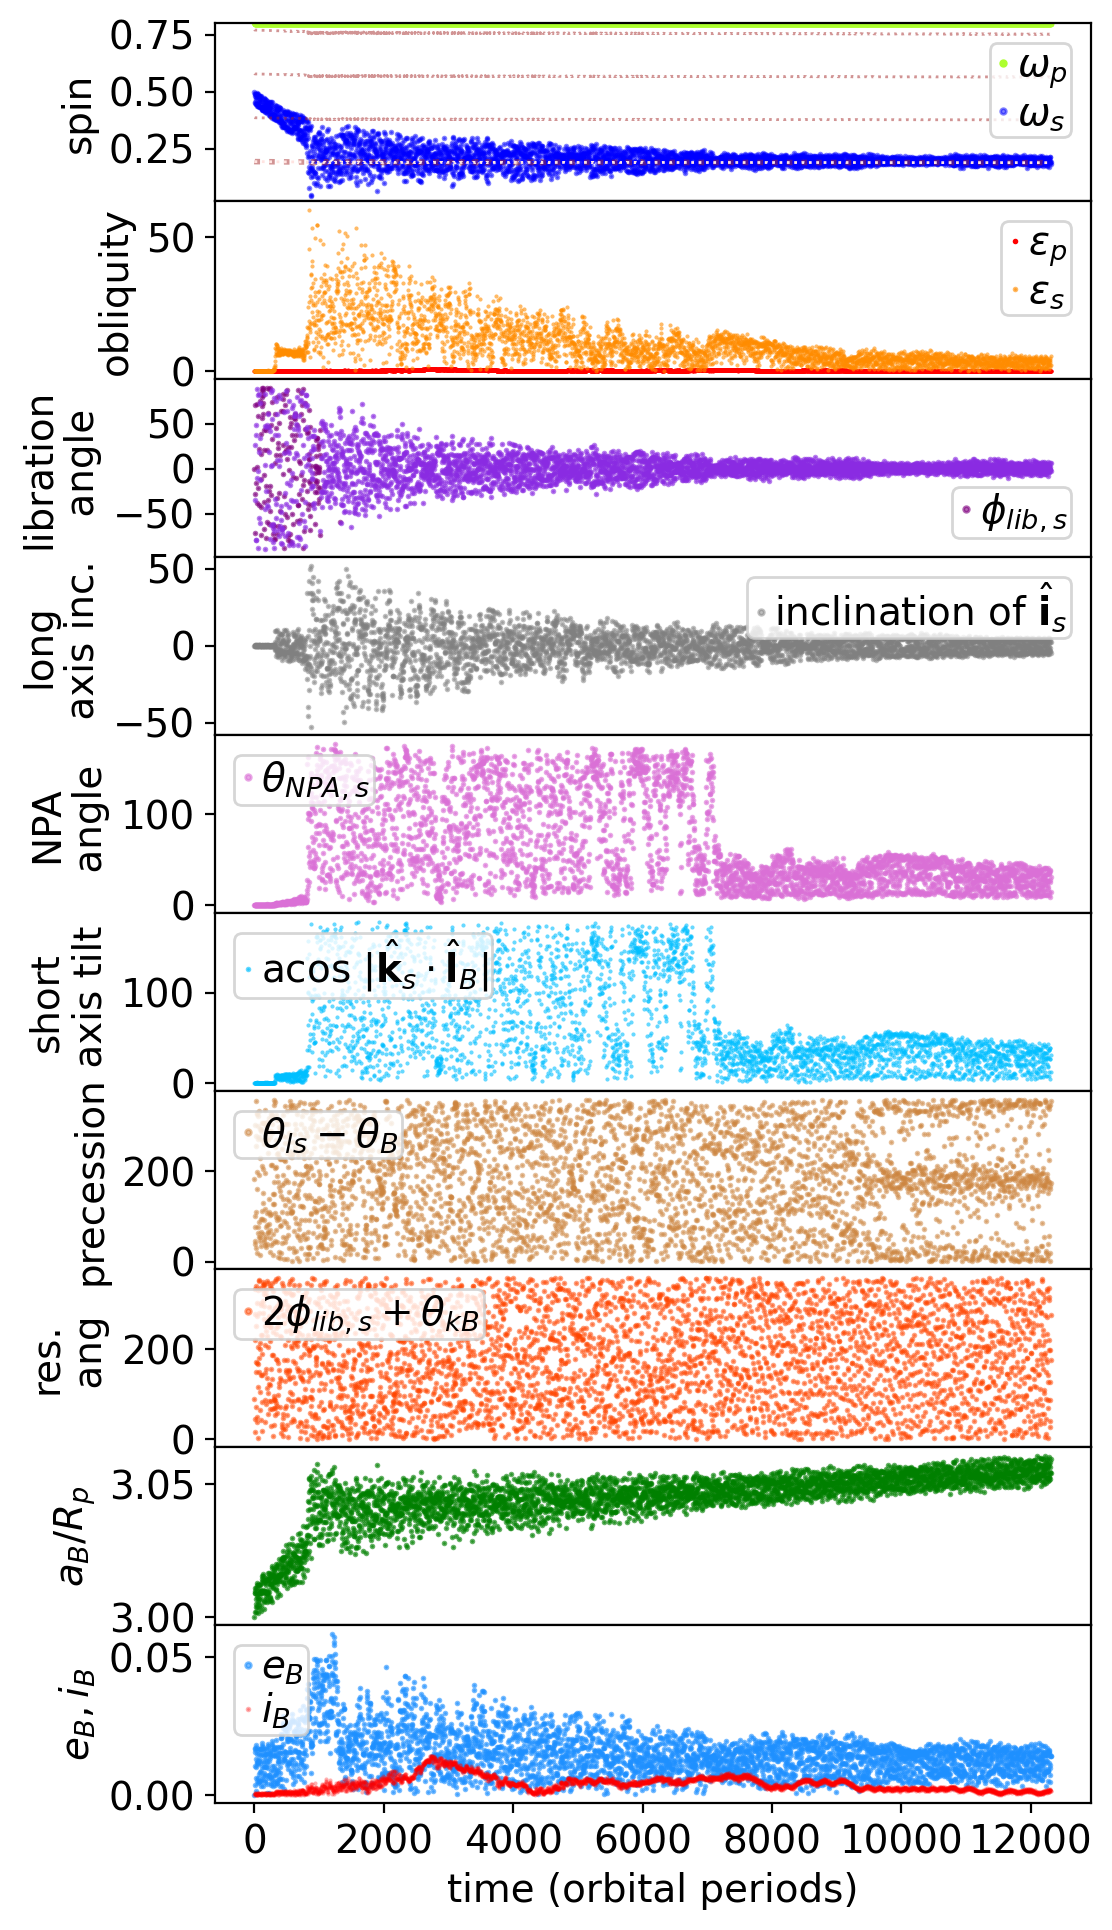

In [461]:
tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,theta_k,\
        theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
    = read_two_bodies_new(simdir,froot,GM)
mkplot_new(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
       lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
       theta_k,theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
       ,50,tmin,tmax,ofilename)

In [403]:
i0=0; ni=100; di=3000
t_B_s, tau_L_iv_s = BY_ave_interval(sphere.vertices,sphere.faces,tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)


In [404]:
i0=0; ni=100; di=3000
t_B_b1, tau_L_iv_b1 = BY_ave_interval(body1.vertices,body1.faces,tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)


In [405]:
t_B_ss1, tau_L_iv_ss1  = BY_ave_interval(short_squannit1.vertices,short_squannit1.faces,\
                                         tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)
#t_B_ss1p, tau_L_iv_ss1p  = BY_ave_interval(short_squannit1_p.vertices,short_squannit1_p.faces,\
#                                           tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)

Text(0, 0.5, 'B')

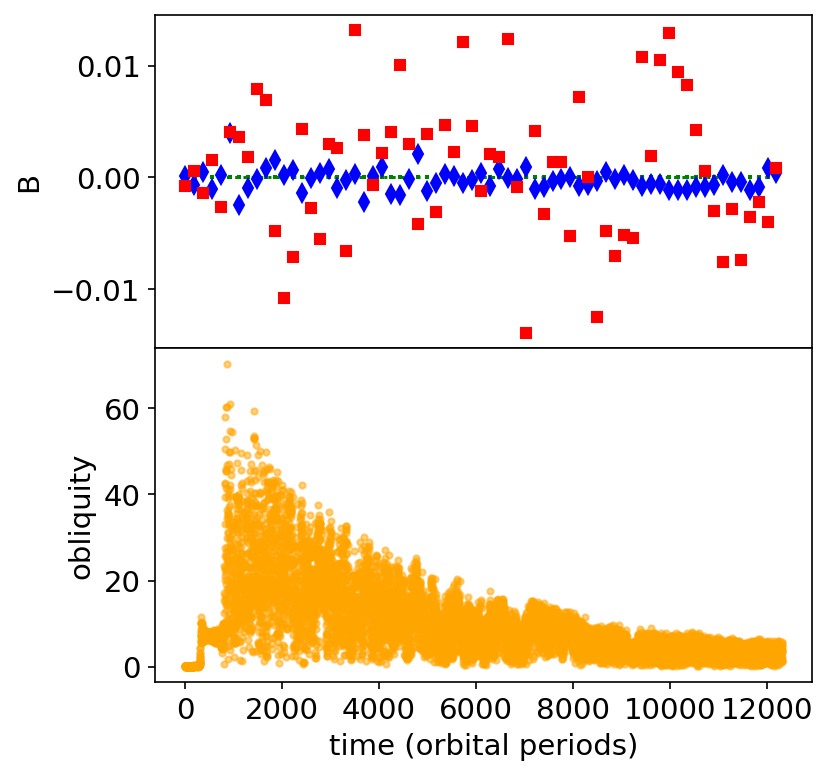

In [407]:
fig,axarr = plt.subplots(2,1,figsize=(6,5),dpi=150,sharex=True)
plt.subplots_adjust(left=0.23, right=0.96, top=0.99, bottom=0.10, \
        wspace=0.22, hspace=0.0)
axarr[0].plot(t_B_s/P_orb,tau_L_iv_s,'gs:',ms=1)
axarr[0].plot(t_B_b1/P_orb,tau_L_iv_b1,'bd')
axarr[0].plot(t_B_ss1/P_orb, tau_L_iv_ss1 ,'rs',ms=5)
#axarr[0].plot(t_B_ss1p/P_orb, tau_L_iv_ss1p ,'P',color='violet')
axarr[1].plot(tarr[i0::20]/P_orb,lobliquity_deg2[i0::20],'.',alpha=0.5,color='orange')
axarr[1].set_xlabel('time (orbital periods)')
axarr[1].set_ylabel('obliquity')
axarr[0].set_ylabel('B')

In [354]:
print(np.mean(tau_a_b1), np.mean(-tau_a_ss1))

3.587069619093181e-06 -0.004806098513321682


../bin5/b1c_ext_1.txt
../bin5/b1c_ext_2.txt
../bin5/b1c_cov_2.txt
Porb 33.37


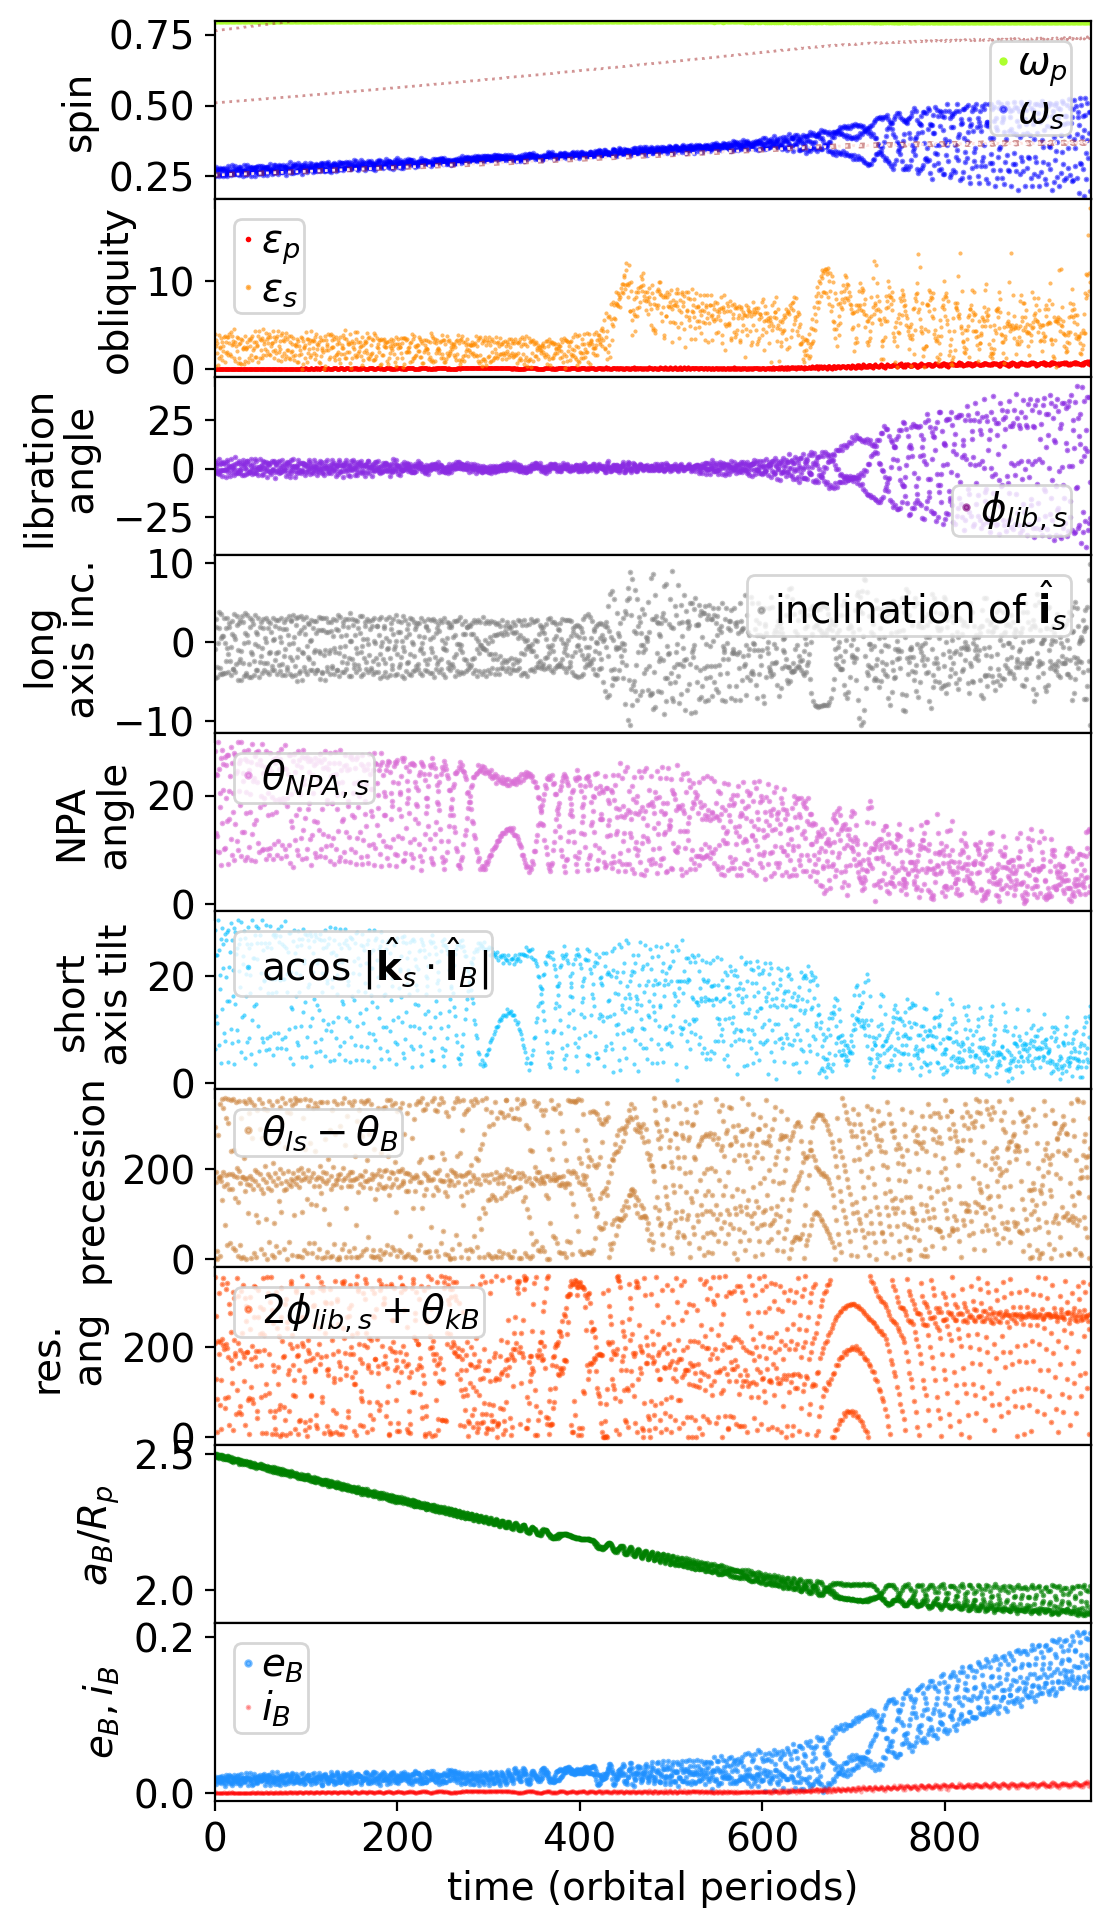

In [462]:
froot = 'b1c'  # no tides, drift inward semi-major axis
ofilename='b1c_new.png'  # in paper
tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,theta_k,\
        theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
    = read_two_bodies_new(simdir,froot,GM)
mkplot_new(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
       lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
       theta_k,theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
       ,10,600,1560,ofilename)   # 600,1560

In [463]:
i0=0; ni=100; di=500
t_B_ss1, tau_L_iv_ss1  = BY_ave_interval(short_squannit1.vertices,short_squannit1.faces,\
                                         tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)

(-4.400597281550071, 20.0)

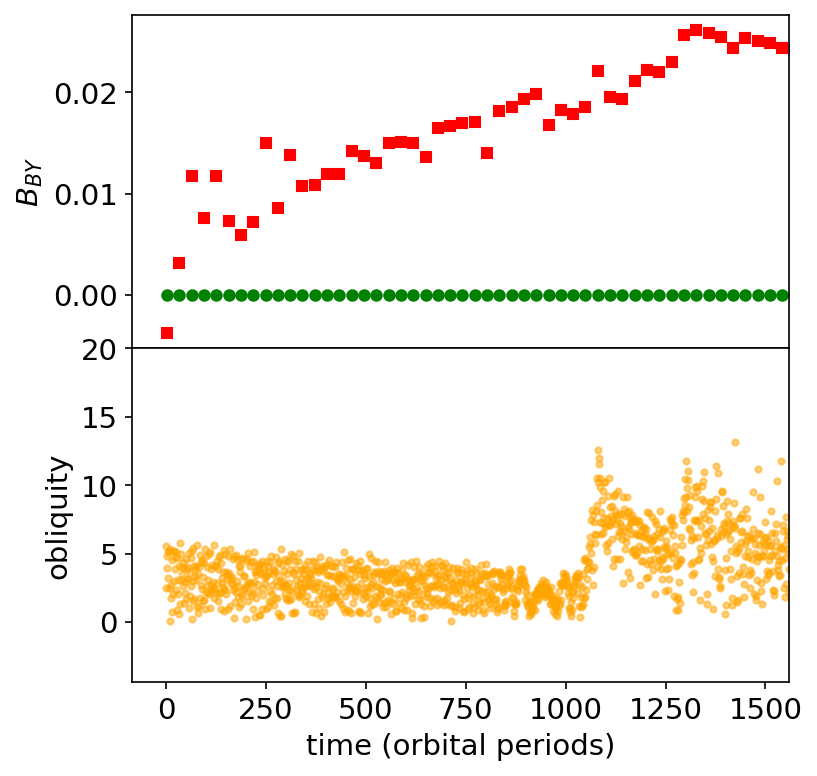

In [466]:
fig,axarr = plt.subplots(2,1,figsize=(6,5),dpi=150,sharex=True)
plt.subplots_adjust(left=0.23, right=0.96, top=0.99, bottom=0.10, \
        wspace=0.22, hspace=0.0)
#axarr[0].plot(t_B_s/P_orb,tau_L_iv_s,'gs:',ms=1)
#axarr[0].plot(t_B_b1/P_orb,tau_L_iv_b1,'bd')
axarr[0].plot(t_B_ss1/P_orb, tau_L_iv_ss1*0 ,'go',ms=5)
axarr[0].plot(t_B_ss1/P_orb, -tau_L_iv_ss1 ,'rs',ms=5)
axarr[0].set_ylabel(r'$B_{BY}$')
#axarr[0].plot(t_B_ss1p/P_orb, tau_L_iv_ss1p ,'P',color='violet')
axarr[1].plot(tarr[i0::20]/P_orb,lobliquity_deg2[i0::20],'.',alpha=0.5,color='orange')
axarr[1].set_xlabel('time (orbital periods)')
axarr[1].set_ylabel('obliquity')
axarr[0].set_xlim(right=1560)
axarr[1].set_ylim(top=20)


In [343]:
i0 = len(tarr) - 1000 
display_shapes(short_squannit1.vertices,short_squannit1.faces,qarr2,abin_arr,i0)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0092156…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.007551…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.021790…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0043930…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0343374…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001210…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.032802…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001955…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0271682…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0051341…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.021681…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.008288…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0161364…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0114374…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.010565…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.014549…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0080996…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0132203…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.008186…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.010037…

### to trouble shoot, looking  at the  outputs of a  tidally locked simulation and making a plot of body orientation  and binary axis to make sure it looks sensible

../bin5/s1_ext_1.txt
../bin5/s1_ext_2.txt
../bin5/s1_cov_2.txt
Porb 32.49
Orbital period 32.5
tmax = 1.50e+03 tmax/P = 46.17


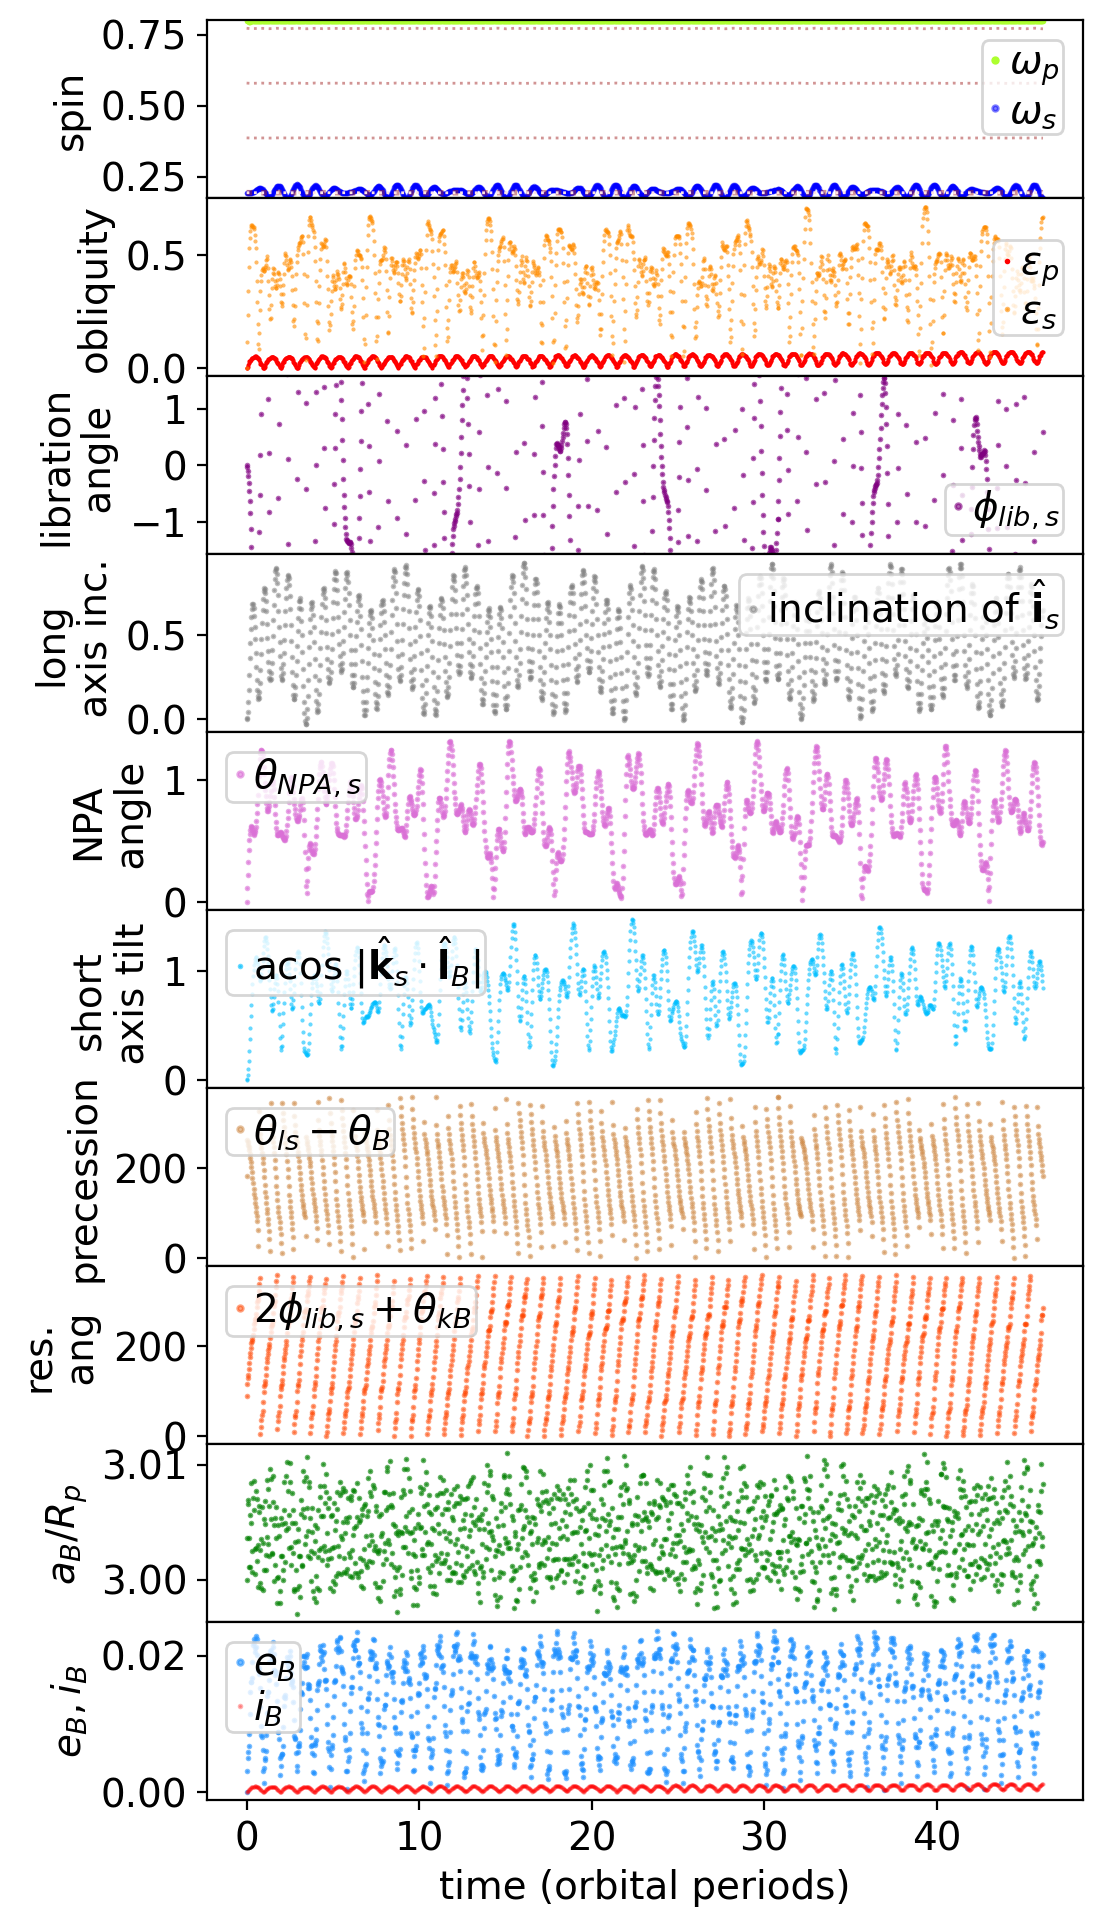

In [430]:
froot = 's1'  # tidally locked for testing
ofilename=''  
tmax=-1;tmin=0; #print(4e5/32.49)  # t in P_B
tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,theta_k,\
        theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
    = read_two_bodies_new(simdir,froot,GM)
mkplot_new(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
       lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
       theta_k,theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
       ,1,tmin,tmax,ofilename)

P_orb = 2*np.pi/meanmotion[0]
print('Orbital period {:.1f}'.format(P_orb))
# how many orbital periods do we have right now?
print('tmax = {:.2e} tmax/P = {:.2f}'.format(max(tarr), max(tarr/P_orb)))

Text(0.5, 0, 'time')

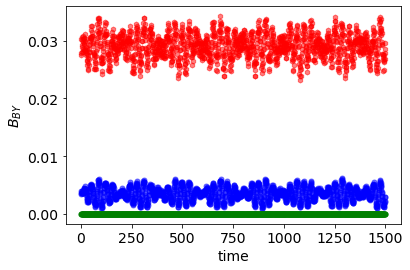

In [419]:
tau_a_s = compute_BY_orbit_ave(sphere.vertices,sphere.faces,qarr2,abin_arr,lbin_arr)
tau_a_b1= compute_BY_orbit_ave(body1.vertices, body1.faces ,qarr2,abin_arr,lbin_arr)
tau_a_ss1= compute_BY_orbit_ave(short_squannit1.vertices, short_squannit1.faces ,qarr2,abin_arr,lbin_arr)
# takes a while even for t=1000!
i0 =0; i1 = len(tarr)
plt.plot(tarr[i0:i1],-tau_a_b1[i0:i1],'bo',ms=5,alpha=0.5)
plt.plot(tarr[i0:i1],tau_a_s[i0:i1],'go',ms=5,alpha=0.5)
plt.plot(tarr[i0:i1],tau_a_ss1[i0:i1],'hr',ms=5,alpha=0.5)
# joy!
plt.ylabel(r'$B_{BY}$')
plt.xlabel(r'time')
# sqannit is about the right size!

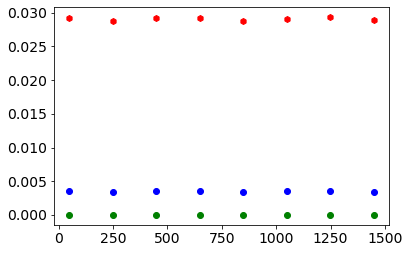

In [420]:
i0=0; ni=100; di = 200
t_B_s, tau_L_iv_s = BY_ave_interval(sphere.vertices,sphere.faces,tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)
t_B_b1, tau_L_iv_b1 = BY_ave_interval(body1.vertices,body1.faces,tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)
t_B_ss1, tau_L_iv_ss1 = BY_ave_interval(short_squannit1.vertices,short_squannit1.faces,tarr,qarr2,abin_arr,lbin_arr,i0,ni,di)
plt.plot(t_B_s,tau_L_iv_s,'go')
plt.plot(t_B_b1,-tau_L_iv_b1,'bo')
plt.plot(t_B_ss1,tau_L_iv_ss1,'rh')
# joy squannit is the right size too

../bin5/s2_ext_1.txt
../bin5/s2_ext_2.txt
../bin5/s2_cov_2.txt
Porb 32.62
Orbital period 32.6
tmax = 5.83e+02 tmax/P = 17.87


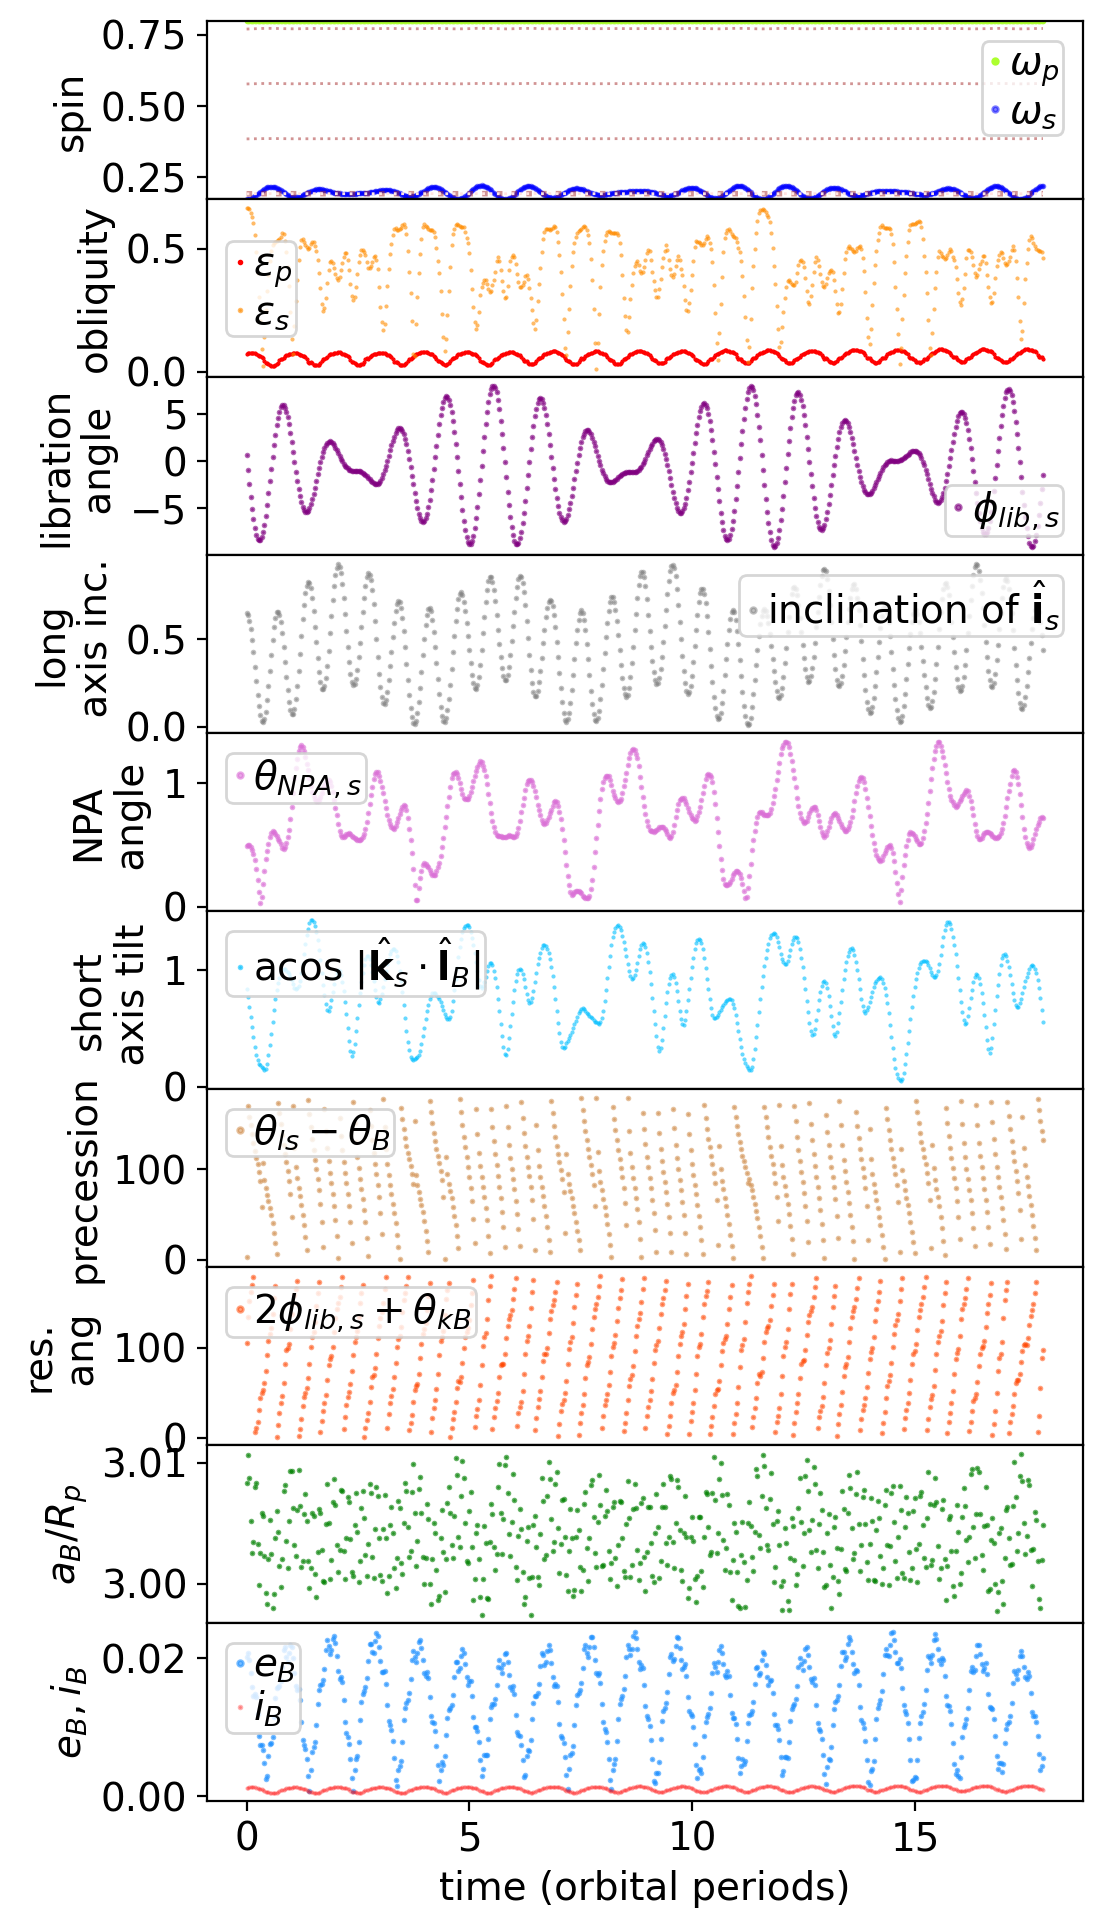

In [421]:
froot = 's2'  
ofilename=''  
tmax=-1;tmin=0; #print(4e5/32.49)  # t in P_B
tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
        lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,theta_k,\
        theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
    = read_two_bodies_new(simdir,froot,GM)
mkplot_new(tarr,aaarr,eearr,iiarr,lnarr,ararr,maarr,om1,om2,\
        lobliquity_deg1,lobliquity_deg2,sobliquity_deg2,meanmotion,\
       lib_angle2,lprec_ang2,sprec_ang2,nprec_ang2,phi1,phi2,theta_B,\
       theta_k,theta2_NPA,ntilt2,longtilt2,qarr2,abin_arr,lbin_arr\
       ,1,tmin,tmax,ofilename)

P_orb = 2*np.pi/meanmotion[0]
print('Orbital period {:.1f}'.format(P_orb))
# how many orbital periods do we have right now?
print('tmax = {:.2e} tmax/P = {:.2f}'.format(max(tarr), max(tarr/P_orb)))

In [232]:
xmax=1.5
# test our rotations
for i in range(20):
        q = qarr[i]  # quaternion specifying body direction 
        #s_hat = np.squeeze(s_hat_arr[i,:]) # solar direction vector
        # rotate the body!
        tvertices =quaternion.rotate_vectors(q, body1.vertices) 
        p = plt_mesh_square(tvertices,body1.faces,xmax)  # body 1 xz plane
        a_x = xmax*abin_arr[i,0]  # binary direction
        a_y = xmax*abin_arr[i,1]
        a_z = xmax*abin_arr[i,2]
        
        v_corn = np.array([[0, 0, 0], [a_x, a_y, a_z],])  #points
        e_corn = np.array([[0, 1]])
        p.add_edges(v_corn, e_corn, shading={"line_color": "blue"});
        

# All looks good! success!

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.026061…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.023115…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016094…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0032590…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0081250…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.004397…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.009137…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.023941…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0018690…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.008243…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.004213…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0183724…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0215159…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001992…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0032737…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0230661…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0264542…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0235438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0192241…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002864…

array([ 5.55111512e-17,  4.34054719e-01,  8.49917032e-01, ...,
        3.75304313e-01, -7.48237878e-02, -5.18832456e-01])

In [342]:
def display_shapes(vertices,faces,qarr,abin_arr,i0):
    xmax=1.5
    # test our rotations
    for j in range(20):
        i =i0+j
        q = qarr[i]  # quaternion specifying body direction 
        #s_hat = np.squeeze(s_hat_arr[i,:]) # solar direction vector
        # rotate the body!
        tvertices =quaternion.rotate_vectors(q, vertices) 
        p = plt_mesh_square(tvertices,faces,xmax)  # body 1 xz plane
        a_x = xmax*abin_arr[i,0]  # binary direction
        a_y = xmax*abin_arr[i,1]
        a_z = xmax*abin_arr[i,2]
        
        v_corn = np.array([[0, 0, 0], [a_x, a_y, a_z],])  #points
        e_corn = np.array([[0, 1]])  # show the vector to the primary 
        p.add_edges(v_corn, e_corn, shading={"line_color": "blue"});
        

